In [1]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import time

from solver import Solver
from dataset import SytheticData
from model import marmousi2, box_smooth

In [2]:
from utils_plot import plot_model, plot_section

In [3]:
# Device 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device={device}')

device=cuda


In [4]:
# Mesh Configurations
h = 0.01
dt = 0.001
nx = 200
nz = 100
nt = 1600
f0 = 10
t0 = 1/f0

cfl = 4 * dt / h
npw = 4 / f0 / h
print('CFL number is about' + f' {cfl:.2f}')
print('Number of grid points per wave length is about' + f' {npw:.1f}')

CFL number is about 0.40
Number of grid points per wave length is about 40.0


In [5]:
# Training configurations
num_epochs = 200
# batch_size = 16
batch_size = 8
learning_rate = 0.001
shuffle = True

In [6]:
# Sources and receivers
sx = np.arange(1, nx)
sources_xz = np.c_[np.ones_like(sx), sx]
rx = np.arange(1, nx)
receivers_xz = np.c_[2*np.ones_like(rx), rx]

In [7]:
# True model
path_rho = '/root/autodl-nas/geodata/marmousi2/AS-marmousi_II.rho-cut'
path_vp = '/root/autodl-nas/geodata/marmousi2/AS-marmousi_II.vp-cut'
path_vs = '/root/autodl-nas/geodata/marmousi2/AS-marmousi_II.vs-cut'
rho, vp, vs = marmousi2(nz, nx, path_rho, path_vp, path_vs)
rho /= 1000
vp /= 1000
vs /= 1000

Text(0.5, 1.0, '$V_s$ in Marmousi2')

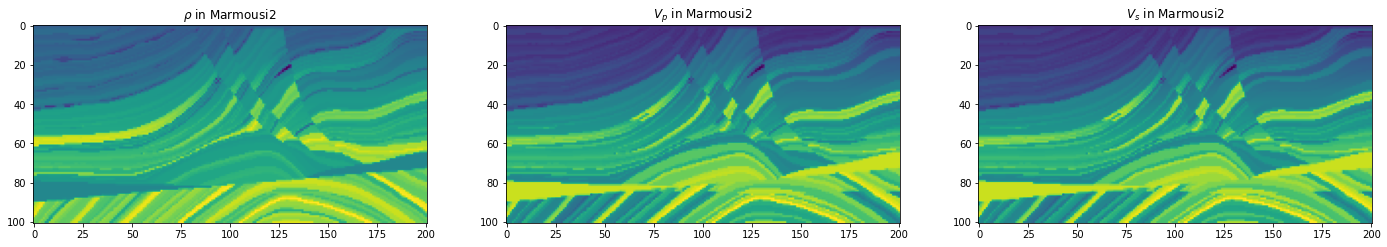

In [8]:
plt.figure(figsize=(24, 4))
plt.subplot(131)
plt.imshow(rho, aspect='equal')
plt.title(r'$\rho$ in Marmousi2')
plt.subplot(132)
plt.imshow(vp, aspect='equal')
plt.title(r'$V_p$ in Marmousi2')
plt.subplot(133)
plt.imshow(vs, aspect='equal')
plt.title(r'$V_s$ in Marmousi2')

In [9]:
print('rho in ({:.2f}, {:.2f})'.format(rho.min(), rho.max()))
print('vp in ({:.2f}, {:.2f})'.format(vp.min(), vp.max()))
print('vs in ({:.2f}, {:.2f})'.format(vs.min(), vs.max()))

rho in (1.72, 2.63)
vp in (1.53, 4.77)
vs in (0.88, 2.75)


In [10]:
# Dataset and dataloader
rho_true = torch.from_numpy(rho).to(torch.float32)
vp_true = torch.from_numpy(vp).to(torch.float32)
vs_true = torch.from_numpy(vs).to(torch.float32)
dataset = SytheticData(rho_true, vp_true, vs_true, h, dt, nt, t0, f0, sources_xz, receivers_xz)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
# Initial model
rho_initial = box_smooth(rho_true, 40, 40).to(device)
vp_initial = box_smooth(vp_true, 40, 40).to(device)
vs_initial = box_smooth(vs_true, 40, 40).to(device)
rho_initial_numpy = rho_initial.clone().cpu().numpy()
vp_initial_numpy = vp_initial.clone().cpu().numpy()
vs_initial_numpy = vs_initial.clone().cpu().numpy()
rho_initial.requires_grad = True
vp_initial.requires_grad = True
vs_initial.requires_grad = True

In [12]:
# Initial solver
solver_initial = Solver(rho_initial, vp_initial, vs_initial, h, dt, nt, t0, f0, receivers_xz)

In [13]:
# Loss function
criterion = torch.nn.MSELoss()

In [14]:
# Optimizer 
all_params = [rho_initial, vp_initial, vs_initial]
optimizer = torch.optim.Adam(all_params, lr=learning_rate)
# optimizer = torch.optim.RMSprop(all_params, lr=learning_rate)
# optimizer = torch.optim.NAdam(all_params, lr=learning_rate)
# optimizer = torch.optim.Adamax(all_params, lr=learning_rate)
# optimizer = torch.optim.Adadelta(all_params, lr=learning_rate)
# optimizer = torch.optim.Adagrad(all_params, lr=learning_rate)

In [15]:
# Logger 
loss_list = []

In [16]:
# Training
time_begin_train = time.time()
n_batch = 0
for n_epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        n_batch += 1
        time_begin = time.time()
        sx, vx_obs, vy_obs = data 
        optimizer.zero_grad()
        vx, vy = solver_initial.step(sx)
        loss_val = criterion(vx, vx_obs.to(device)) + criterion(vy, vy_obs.to(device)) # ?
        loss_val.backward()
        loss_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss={loss_val:.6f}, time={time_end - time_begin:.2f}s")
time_end_train = time.time()
print(f'Total cost time {time_end_train - time_begin_train:.2f}s')

Epoch 1, Batch 1, loss=0.024258, time=9.00s
Epoch 1, Batch 2, loss=0.018113, time=9.32s
Epoch 1, Batch 3, loss=0.026017, time=9.05s
Epoch 1, Batch 4, loss=0.022980, time=7.95s
Epoch 1, Batch 5, loss=0.021177, time=10.23s
Epoch 1, Batch 6, loss=0.018121, time=8.93s
Epoch 1, Batch 7, loss=0.016965, time=8.99s
Epoch 1, Batch 8, loss=0.015291, time=9.68s
Epoch 1, Batch 9, loss=0.019292, time=8.97s
Epoch 1, Batch 10, loss=0.021864, time=9.75s
Epoch 1, Batch 11, loss=0.022206, time=8.39s
Epoch 1, Batch 12, loss=0.019565, time=8.54s
Epoch 1, Batch 13, loss=0.019167, time=8.59s
Epoch 1, Batch 14, loss=0.019395, time=8.52s
Epoch 1, Batch 15, loss=0.019768, time=9.09s
Epoch 1, Batch 16, loss=0.019303, time=8.56s
Epoch 1, Batch 17, loss=0.017743, time=8.96s
Epoch 1, Batch 18, loss=0.019477, time=8.32s
Epoch 1, Batch 19, loss=0.018849, time=8.34s
Epoch 1, Batch 20, loss=0.019104, time=8.38s
Epoch 1, Batch 21, loss=0.016457, time=8.40s
Epoch 1, Batch 22, loss=0.017279, time=8.35s
Epoch 1, Batch 23,

In [17]:
rho_inversion = rho_initial.detach().cpu().numpy()
vp_inversion = vp_initial.detach().cpu().numpy()
vs_inversion = vs_initial.detach().cpu().numpy()

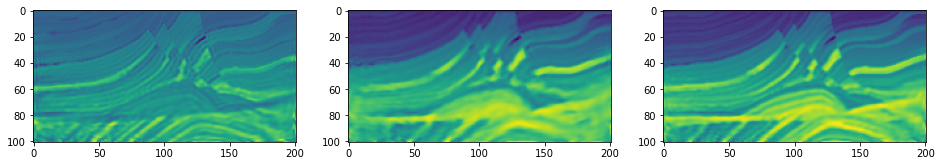

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(rho_inversion)
plt.subplot(132)
plt.imshow(vp_inversion)
plt.subplot(133)
plt.imshow(vs_inversion)

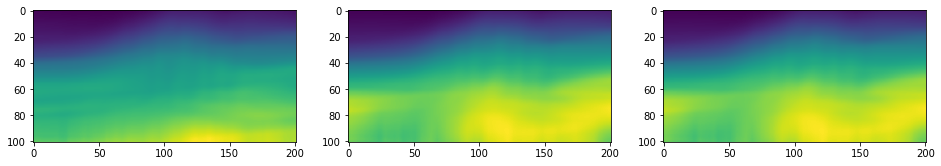

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(rho_initial_numpy)
plt.subplot(132)
plt.imshow(vp_initial_numpy)
plt.subplot(133)
plt.imshow(vs_initial_numpy)

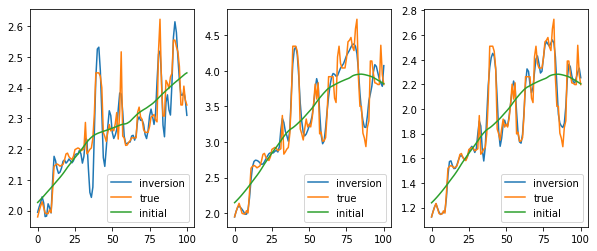

In [20]:
ncol = 100
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.plot(rho_inversion[:, ncol], label='inversion')
plt.plot(rho_true[:, ncol], label='true')
plt.plot(rho_initial_numpy[:, ncol], label='initial')
plt.legend()
plt.subplot(132)
plt.plot(vp_inversion[:, ncol], label='inversion')
plt.plot(vp_true[:, ncol], label='true')
plt.plot(vp_initial_numpy[:, ncol], label='initial')
plt.legend()
plt.subplot(133)
plt.plot(vs_inversion[:, ncol], label='inversion')
plt.plot(vs_true[:, ncol], label='true')
plt.plot(vs_initial_numpy[:, ncol], label='initial')
plt.legend()

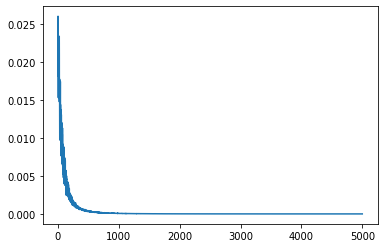

In [21]:
plt.plot(loss_list)

In [23]:
path = './data/marmousi_rho_rmsprop/'
np.save(path+'rho_true', rho)
np.save(path+'rho_initial', rho_initial_numpy)
np.save(path+'rho_inversion', rho_inversion)
np.save(path+'vp_true', vp)
np.save(path+'vp_initial', vp_initial_numpy)
np.save(path+'vp_inversion', vp_inversion)
np.save(path+'vs_true', vs)
np.save(path+'vs_initial', vs_initial_numpy)
np.save(path+'vs_inversion', vs_inversion)
np.save(path+'loss', np.array(loss_list))